In [322]:
import os
os.chdir('../')
from python_code import local_regression
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.stats import multivariate_normal
from matplotlib.collections import LineCollection

## covariance functions

In [334]:
def calculate_matern_covariance_function(x, b, tau_sq_1, tau_sq_2):
    distance = distance_matrix(x, x)
    C = tau_sq_1 * np.exp(-1/2 * (distance/b)**2) + tau_sq_2 * np.eye(x.shape[0])
    return C

def calculate_matern_covariance_function_52(x, b, tau_sq_1, tau_sq_2):
    distance = distance_matrix(x, x)
    C = tau_sq_1 *  (1 + np.sqrt(5)*distance/b + 5*distance**2/(3*b**2)) * np.exp(-np.sqrt(5)*distance/b) + tau_sq_2 * np.eye(x.shape[0])
    return C

## 2D example

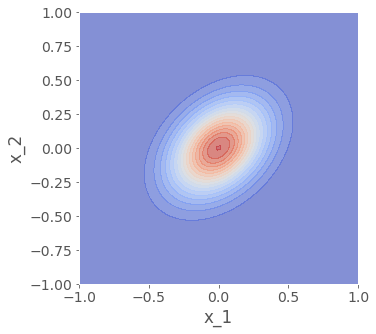

In [336]:
plt.figure(figsize=(5,5))
x = np.array([0,1]).reshape(-1,1)
C = calculate_matern_covariance_function(x, .7, 0.05, 1e-6)
mean = np.zeros(x.shape[0])
dist = multivariate_normal(mean=mean, cov=C)
x_plot = np.linspace(-1,1,100)
xx, yy = np.meshgrid(x_plot, x_plot)
X = np.vstack((xx.flatten(), yy.flatten()))
plt.contourf(x_plot, x_plot, dist.pdf(X.T).reshape(100,100), 20, cmap='coolwarm', alpha = .6)
plt.grid(False)
plt.xlabel('x_1')
plt.ylabel('x_2');

## (A) draw 0 mean GP from [0,1]

In [337]:
x = np.linspace(0,1,100).reshape(-1,1)

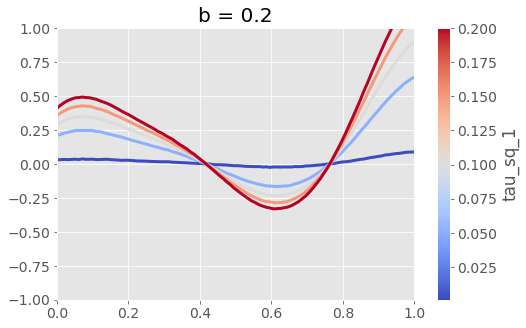

In [338]:
lines = []
tau_range = np.linspace(0.001, 0.2, 5)
for tau_sq_1 in tau_range:
    np.random.seed(2)
    C = calculate_matern_covariance_function(x, .2, tau_sq_1, 1e-6)
    mean = np.zeros(x.shape[0])
    dist = multivariate_normal(mean=mean, cov=C)
    lines.append(np.column_stack([x, dist.rvs()]))
    
fig, ax = plt.subplots(figsize=(8,5))
lc = LineCollection(lines, cmap='coolwarm',array=tau_range,linewidth=3)
line = ax.add_collection(lc) #add to the subplot
ax.set_ylim(-1,1)
fig.colorbar(line, label='tau_sq_1')
plt.title('b = 0.2');

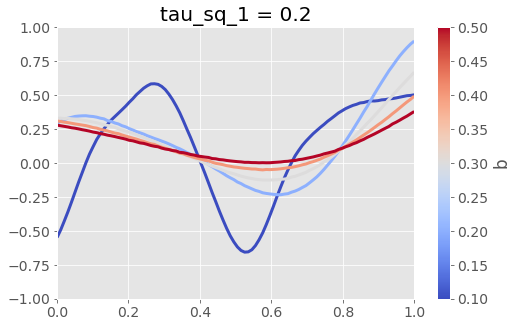

In [339]:
lines = []
b_range = np.linspace(0.1, .5, 5)
for b in b_range:
    np.random.seed(2)
    C = calculate_matern_covariance_function(x, b, 0.1, 1e-6)
    mean = np.zeros(x.shape[0])
    dist = multivariate_normal(mean=mean, cov=C)
    lines.append(np.column_stack([x, dist.rvs()]))
    
fig, ax = plt.subplots(figsize=(8,5))
tau_range = np.linspace(0.001, 0.1, 10)
lc = LineCollection(lines, cmap='coolwarm',array=b_range,linewidth=3)
line = ax.add_collection(lc) #add to the subplot
ax.set_ylim(-1,1)
fig.colorbar(line, label='b');
plt.title('tau_sq_1 = 0.2');

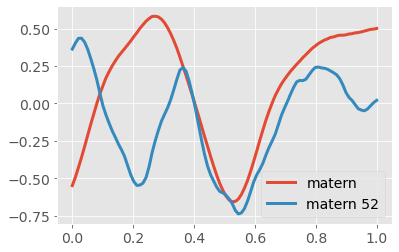

In [340]:
np.random.seed(2)
C = calculate_matern_covariance_function(x, .1, 0.1, 1e-6)
mean = np.zeros(x.shape[0])
dist = multivariate_normal(mean=mean, cov=C)
plt.plot(x, dist.rvs(), lw=3, label='matern')
C = calculate_matern_covariance_function_52(x, .1, 0.1, 1e-6)
dist = multivariate_normal(mean=mean, cov=C)
plt.plot(x, dist.rvs(), lw=3, label='matern 52')
plt.legend()

## (B) fit data to existing points

In [348]:
n_points = 50
x = np.linspace(0,10,n_points)
y = np.sin(x) + np.random.normal(0,.5, size=n_points)

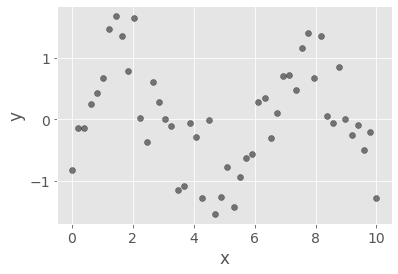

In [352]:
plt.scatter(x, y, color='black', alpha=.5)
plt.xlabel('x')
plt.ylabel('y');